In [112]:
#intall ytdl in environment
!pip install yt-dlp
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import os
from pathlib import Path
import tensorflow as tf
from tensorflow import keras
from yt_dlp import YoutubeDL
from sklearn.metrics import confusion_matrix

In [41]:
#mount drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [42]:
#load in list of songs from other model's test data
spotify_songlist = "/content/drive/MyDrive/ML data/SpotifySongs.csv"
spotify_val = pd.read_csv(spotify_songlist)
spotify_val = spotify_val.dropna()

In [ ]:
#edit labels to exactly match spectrogram data
# Use Series.replace for efficient label mapping
genre_mapping = {
    "Rock": "rock_punk",
    "r&b": "funk_soul_rnb",
    "hip-hop": "hiphop_rap",
    "country": "folk_country",
    "folk": "folk_country",
    "electronic": "electronic_edm",
    "classical": "classical_orchestral"
}
spotify_val["Genre"] = spotify_val["Genre"].replace(genre_mapping)

#drop latin, afrobeats, and and indian
spotify_val = spotify_val[spotify_val["Genre"] != "latin"]
spotify_val = spotify_val[spotify_val["Genre"] != "afrobeats"]
spotify_val = spotify_val[spotify_val["Genre"] != "indian"]

#note that we are missing jazz

In [ ]:
#drop api column
spotify_val = spotify_val.drop(columns=["API link"])
spotify_val

,Genre,Artist,Title
0,pop,"Lady Gaga, Bruno Mars",Die With A Smile
1,pop,Billie Eilish,BIRDS OF A FEATHER
2,pop,Gracie Abrams,That’s So True
3,pop,Sabrina Carpenter,Taste
4,pop,"ROSÉ, Bruno Mars",APT.
...,...,...,...
174,ambient,"Dave, Central Cee",Sprinter
175,ambient,"Victony, Rema, Tempoe, Don Toliver","Soweto (with Don Toliver, Rema & Tempoe)"
176,ambient,Ayra Starr,Rush
177,ambient,Tems,Free Mind


In [ ]:
#download spotify_val
spotify_val.to_csv("spotify_val.csv", index=False)
files.download("spotify_val.csv")

In [99]:
#load in new edited csv with youtube links
spotify_yt = pd.read_csv("/content/drive/MyDrive/ML data/spotify_links.csv")
spotify_yt

,Genre,Artist,Title,yt_link
0,pop,"Lady Gaga, Bruno Mars",Die With A Smile,https://www.youtube.com/watch?v=vrorJGCx0L8
1,pop,Billie Eilish,BIRDS OF A FEATHER,https://www.youtube.com/watch?v=F4SLXq8mzgI
2,pop,Gracie Abrams,That’s So True,https://www.youtube.com/watch?v=W_YOJWZIjxo
3,pop,Sabrina Carpenter,Taste,https://www.youtube.com/watch?v=KEG7b851Ric
4,pop,"ROSÉ, Bruno Mars",APT.,https://www.youtube.com/watch?v=58-AKkNMZNQ
...,...,...,...,...
106,ambient,"Dave, Central Cee",Sprinter,https://youtu.be/ThGpv7kv6Iw?si=sxnpEzBqMtv4vAsT
107,ambient,"Victony, Rema, Tempoe, Don Toliver","Soweto (with Don Toliver, Rema & Tempoe)",https://www.youtube.com/watch?v=OGAngW1BZ04
108,ambient,Ayra Starr,Rush,https://youtu.be/VAXGYrtO6gY?si=aMsWyUgb32fFwGov
109,ambient,Tems,Free Mind,https://youtu.be/mlaTJrQdmiY?si=SydtX_hUfAnSzO9F


The urls above were used to download mp3 files of every song from youtube using YoutubeDL with the code below. As songs have already been downloaded, this code was not ran in the final version of this code.

In [ ]:
import os
from yt_dlp import YoutubeDL

OUTPUT_DIR = "/content/drive/MyDrive/ML data/spotify_audios"
os.makedirs(OUTPUT_DIR, exist_ok=True)

count = 0

for idx, row in rest.iterrows():
    title = row["Title"]
    url = row["yt_link"]

    filename = f"{title}.mp3"
    output_path = os.path.join(OUTPUT_DIR, filename)

    # create a fresh YoutubeDL instance for each download
    ydl_opts = {
        "format": "bestaudio/best",
        "extractaudio": True,
        "audioformat": "mp3",
        "quiet": False,
        "noplaylist": True,
        "outtmpl": output_path
    }

    try:
        with YoutubeDL(ydl_opts) as ydl:
            ydl.download([url])
    except Exception as e:
        print(f"Failed to download {title}: {e}")

    count += 1
    if count % 10 == 0:
        print(f"Downloaded {count} songs")


In [52]:
#add column with filepath
audio_dir = "/content/drive/MyDrive/ML data/spotify_audios"
spotify_yt["filepath"] = spotify_yt["Title"].apply(lambda x: os.path.join(audio_dir, f"{x}.mp3"))

In [58]:
#make spectrograms
sr = 22050

def make_melspec(filepath, sr=sr):
    y, sr = librosa.load(filepath, sr=sr)
    melspec = librosa.feature.melspectrogram(
        y=y,
        sr=sr,
        n_fft=2048,
        hop_length=512,
        n_mels=96,
        fmax=sr // 2,
    )
    melspec = librosa.power_to_db(melspec, ref=np.max)
    return melspec

melspec_df = []
for i in range(len(spotify_yt)):
  melspec_df.append(make_melspec(spotify_yt['filepath'][i]))
  if i % 10 == 0:
    print(i, 'songs converted')

/tmp/ipython-input-1472969244.py:5: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(filepath, sr=sr)  # Removed backend="audioread" argument
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


0 songs converted


/tmp/ipython-input-1472969244.py:5: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(filepath, sr=sr)  # Removed backend="audioread" argument
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/tmp/ipython-input-1472969244.py:5: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(filepath, sr=sr)  # Removed backend="audioread" argument
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/tmp/ipython-input-1472969244.py:5: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa

10 songs converted


/tmp/ipython-input-1472969244.py:5: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(filepath, sr=sr)  # Removed backend="audioread" argument
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/tmp/ipython-input-1472969244.py:5: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(filepath, sr=sr)  # Removed backend="audioread" argument
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/tmp/ipython-input-1472969244.py:5: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa

20 songs converted


/tmp/ipython-input-1472969244.py:5: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(filepath, sr=sr)  # Removed backend="audioread" argument
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/tmp/ipython-input-1472969244.py:5: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(filepath, sr=sr)  # Removed backend="audioread" argument
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/tmp/ipython-input-1472969244.py:5: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa

30 songs converted


/tmp/ipython-input-1472969244.py:5: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(filepath, sr=sr)  # Removed backend="audioread" argument
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/tmp/ipython-input-1472969244.py:5: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(filepath, sr=sr)  # Removed backend="audioread" argument
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/tmp/ipython-input-1472969244.py:5: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa

40 songs converted


/tmp/ipython-input-1472969244.py:5: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(filepath, sr=sr)  # Removed backend="audioread" argument
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/tmp/ipython-input-1472969244.py:5: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(filepath, sr=sr)  # Removed backend="audioread" argument
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/tmp/ipython-input-1472969244.py:5: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa

50 songs converted


/tmp/ipython-input-1472969244.py:5: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(filepath, sr=sr)  # Removed backend="audioread" argument
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/tmp/ipython-input-1472969244.py:5: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(filepath, sr=sr)  # Removed backend="audioread" argument
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/tmp/ipython-input-1472969244.py:5: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa

60 songs converted


/tmp/ipython-input-1472969244.py:5: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(filepath, sr=sr)  # Removed backend="audioread" argument
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/tmp/ipython-input-1472969244.py:5: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(filepath, sr=sr)  # Removed backend="audioread" argument
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/tmp/ipython-input-1472969244.py:5: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa

70 songs converted


/tmp/ipython-input-1472969244.py:5: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(filepath, sr=sr)  # Removed backend="audioread" argument
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/tmp/ipython-input-1472969244.py:5: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(filepath, sr=sr)  # Removed backend="audioread" argument
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/tmp/ipython-input-1472969244.py:5: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa

80 songs converted


/tmp/ipython-input-1472969244.py:5: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(filepath, sr=sr)  # Removed backend="audioread" argument
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/tmp/ipython-input-1472969244.py:5: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(filepath, sr=sr)  # Removed backend="audioread" argument
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/tmp/ipython-input-1472969244.py:5: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa

90 songs converted


/tmp/ipython-input-1472969244.py:5: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(filepath, sr=sr)  # Removed backend="audioread" argument
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/tmp/ipython-input-1472969244.py:5: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(filepath, sr=sr)  # Removed backend="audioread" argument
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/tmp/ipython-input-1472969244.py:5: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa

100 songs converted


/tmp/ipython-input-1472969244.py:5: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(filepath, sr=sr)  # Removed backend="audioread" argument
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/tmp/ipython-input-1472969244.py:5: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(filepath, sr=sr)  # Removed backend="audioread" argument
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/tmp/ipython-input-1472969244.py:5: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa

110 songs converted


In [75]:
#chop spectrograms into 30 seconds clips that will fit into model
min_length = 1400
songs_final = []
specs = []

max_slices = 12
slice_count = {}   # keeps track of how many slices per song

for i in range(len(melspec_df)):
    spec  = melspec_df[i]
    title = spotify_yt['Title'][i]
    length = spec.shape[1]

    # initialize counter for this song if needed
    if title not in slice_count:
        slice_count[title] = 0

    # Case 1: whole spectrogram is short enough
    if length <= min_length:
        if slice_count[title] < max_slices:
            songs_final.append(title)
            specs.append(spec)
            slice_count[title] += 1

    else:
        # Case 2: longer spectrogram → slice into chunks
        num_slices = length // min_length

        for j in range(num_slices):
            if slice_count[title] >= max_slices:
                break  # stop once we hit 12 for this title, some youtube videos ended in ads

            clip = spec[:, j*min_length : (j+1)*min_length]
            songs_final.append(title)
            specs.append(clip)
            slice_count[title] += 1

# confirm shapes
print('total clips:', len(songs_final))
print('total spectrograms:', len(specs))


total clips: 714
total spectrograms: 714


In [77]:
#normalize spectrograms
eps = 1e-6
specs = np.array(specs).reshape(-1, 96, 1400, 1)
specs = (specs - specs.mean(axis=(1,2,3), keepdims=True)) / \
          (specs.std(axis=(1,2,3), keepdims=True) + eps)

In [79]:
#load in model
model = keras.models.load_model("/content/drive/MyDrive/ML data/purecnn_10class.keras") #best model with about 47 percent accuracy

In [80]:
genres = ['ambient',
          'classical_orchestral',
          'electronic_edm',
          'folk_country',
          'funk_soul_rnb',
          'hiphop_rap',
          'jazz_fusion',
          'metal',
          'pop',
          'rock_punk']

In [136]:
#make predicitons
spotify_pred = model.predict(specs)
#put softmax outputs into dataframe with titles
spotify_pred = pd.DataFrame(spotify_pred, columns=genres)
spotify_pred["Title"] = songs_final

23/23 ━━━━━━━━━━━━━━━━━━━━ 356s 15s/step


In [137]:
#sum rows based on title and convert to 1s and 0s
spotify_pred = spotify_pred.groupby("Title").sum()
spotify_pred = spotify_pred.apply(lambda x: x / x.max(), axis=1)
spotify_pred[spotify_pred !=1] = 0


In [139]:
spotify_true = spotify_yt[['Title', 'Genre']]
#hot one encode
spotify_true = pd.get_dummies(spotify_true, columns=['Genre'])


In [140]:
#add column of zeroes for jazz
spotify_true['jazz_fusion'] = False
spotify_true.columns

Index(['Title', 'Genre_ambient', 'Genre_classical_orchestral',
       'Genre_electronic_edm', 'Genre_folk_country', 'Genre_funk_soul_rnb',
       'Genre_hiphop_rap', 'Genre_metal', 'Genre_pop', 'Genre_rock',
       'jazz_fusion'],
      dtype='object')

In [141]:
#reorder columns so they match the predicted data
new_order = ['Title',
             'Genre_ambient',
             'Genre_classical_orchestral',
             'Genre_electronic_edm',
             'Genre_folk_country',
             'Genre_funk_soul_rnb',
             'Genre_hiphop_rap',
             'jazz_fusion',
             'Genre_metal',
             'Genre_pop',
             'Genre_rock']
spotify_true = spotify_true[new_order]

In [148]:
#Timeless (with Playboi Carti) was classified as multiple genres in the training data, i will drop it for simplicity
spotify_pred = spotify_pred.reset_index()
spotify_true = spotify_true[spotify_true["Title"] != "Timeless (with Playboi Carti)"]
spotify_pred = spotify_pred[spotify_pred["Title"] != "Timeless (with Playboi Carti)"]

In [151]:
#reorder rows based on song title so they match
spotify_true = spotify_true.sort_values(by="Title")
spotify_pred = spotify_pred.sort_values(by="Title")

Text(0.5, 1.0, 'Confusion Matrix for 10 class CNN with SpecAugment')

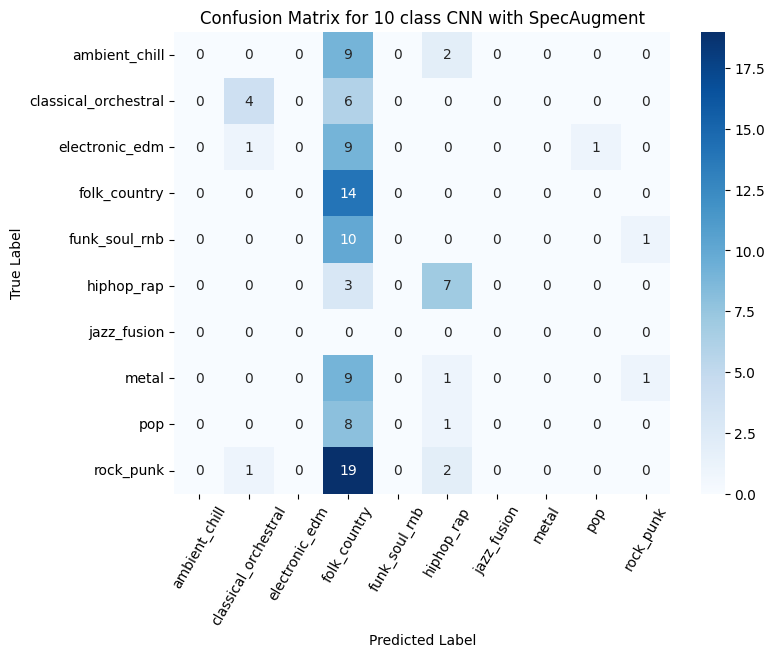

In [160]:
#use spotify_pred and spotify_true to make confusion matrix

genres = ['ambient_chill',
          'classical_orchestral',
          'electronic_edm',
          'folk_country',
          'funk_soul_rnb',
          'hiphop_rap',
          'jazz_fusion',
          'metal',
          'pop',
          'rock_punk']

# Rename columns in spotify_true to match the model's genre names
spotify_true_renamed = spotify_true.copy()
# Create a mapping dictionary for column renaming
column_rename_map = {
    'Genre_ambient': 'ambient_chill',
    'Genre_classical_orchestral': 'classical_orchestral',
    'Genre_electronic_edm': 'electronic_edm',
    'Genre_folk_country': 'folk_country',
    'Genre_funk_soul_rnb': 'funk_soul_rnb',
    'Genre_hiphop_rap': 'hiphop_rap',
    'Genre_metal': 'metal',
    'Genre_pop': 'pop',
    'Genre_rock': 'rock_punk'
}
spotify_true_renamed = spotify_true_renamed.rename(columns=column_rename_map)

# Ensure only the genre columns are selected for comparison and that they are in the correct order
test_true = spotify_true_renamed[genres]
test_predicted = spotify_pred[genres]

# Convert one-hot encoded DataFrames to single label series for confusion_matrix
# idxmax(axis=1) returns the column label of the first occurrence of the maximum value for each row.
y_true_labels = test_true.idxmax(axis=1)
y_pred_labels = test_predicted.idxmax(axis=1)

# Use the `labels` parameter in confusion_matrix to ensure consistent ordering of classes
cm = confusion_matrix(y_true_labels, y_pred_labels, labels=genres)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(ticks=np.arange(len(genres))+0.5, labels=genres, rotation=60)
plt.yticks(ticks=np.arange(len(genres))+0.5, labels=genres, rotation=0)
plt.title('Confusion Matrix for 10 class CNN with SpecAugment')